# Human Resources Analytics: SPOT
## Data Analysis and modeling - Data Driven Business Models (Amazoogle)

### Rafael Rejtman, Marina Gobett, Caroline Smid , Mikela Lazari, Raja Riahi



* **1 Introduction**
* **2 Load and check data**
    * 2.1 load data
    * 2.2 check for missing values
* **3 Global data exploration**
* **4 Detailed data exploration**    
    * 4.1 Normalisation and dimensionalty reduction
    * 4.2 Global Radar Chart
    * 4.3 Left and other features
    * 4.4 Clustering analysis
* **5 Modeling**
    * 5.1 Decision Tree
    * 5.2 Random Forest

## 1. Introduction

The Human Resources Analytics is a dataset providing informations on the situation and work of tens of thousands of employees.

The focus of this kernel is on one very important question : Why are employees leaving a company?**

To tackle this question , this notebook combines data exploration analysis and modeling.

This dataset is perfect for this kind of detailed data exploration because it contains a few number of features a large number of individuals, so we can perform robust statistics. Firstly, we can globally explore the dataset, then focus on a detailed exploration analysis of the target variable and finally, data modeling.

This script follows three main parts:

* **Global data exploration**
* **Detailed target variable exploration**
* **Data modeling**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

import sklearn

from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import pydot
import pydotplus as pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
output_notebook()

import warnings

# import pydotplus

warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

np.random.seed(seed=2)

Loading BokehJS ...

## 2. Load and Check data
### 2.1 Load the data

In [2]:
# Load the data
dataset = pd.read_csv("turnover.csv")

In [3]:
dataset.shape

(14999, 10)

In [4]:
# Look at the train set
dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


- This dataset contains 14999 rows described by 10 features.


- There are 8 numerical features and 2 categorical features.
    - Sales is non nominal
    - Salary is ordinal
    
    
- The target feature is 'left'. It is binary encoded, with 0 for employees that stayed and 1 for the ones who left.

### 2.2 check for missing values

In [5]:
# Check for missing values
dataset.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool

The dataset is clean, with no missing values at all.

## 3. Global data exploration

Histograms of the 10 features are displayed for a global analysis.

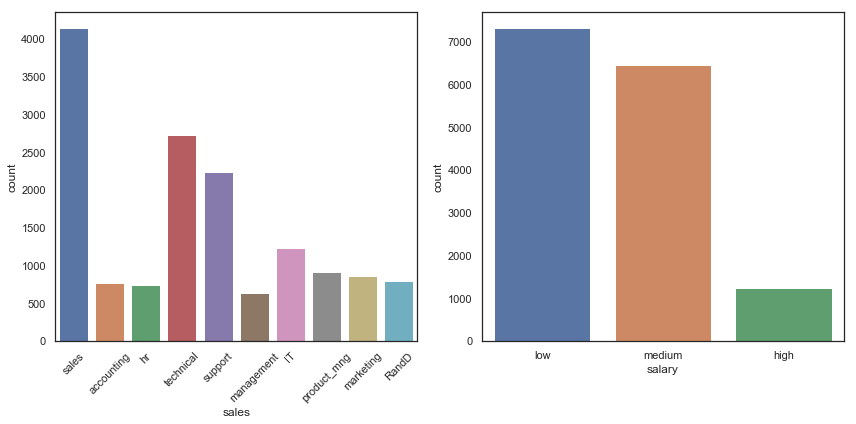

<Figure size 432x288 with 0 Axes>

In [6]:
fig, axs = plt.subplots(ncols=2,figsize=(12,6))
g = sns.countplot(dataset["sales"], ax=axs[0])
plt.setp(g.get_xticklabels(), rotation=45)
g = sns.countplot(dataset["salary"], ax=axs[1])
plt.tight_layout()
plt.show()
plt.gcf().clear()

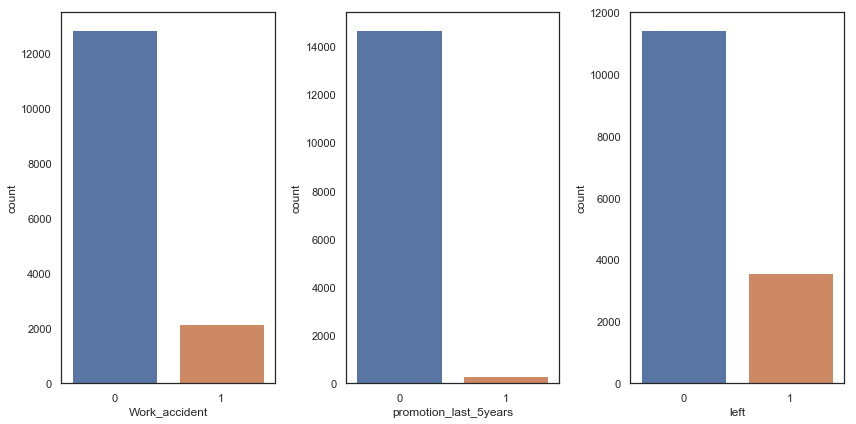

<Figure size 432x288 with 0 Axes>

In [7]:
fig, axs = plt.subplots(ncols=3,figsize=(12,6))
sns.countplot(dataset["Work_accident"], ax=axs[0])
sns.countplot(dataset["promotion_last_5years"], ax=axs[1])
sns.countplot(dataset["left"], ax=axs[2])
plt.tight_layout()
plt.show()
plt.gcf().clear()

- The target variable ('left') is clearly unbalanced. This unbalance, however, is lower than 10x which indicates the analysis is still valid.

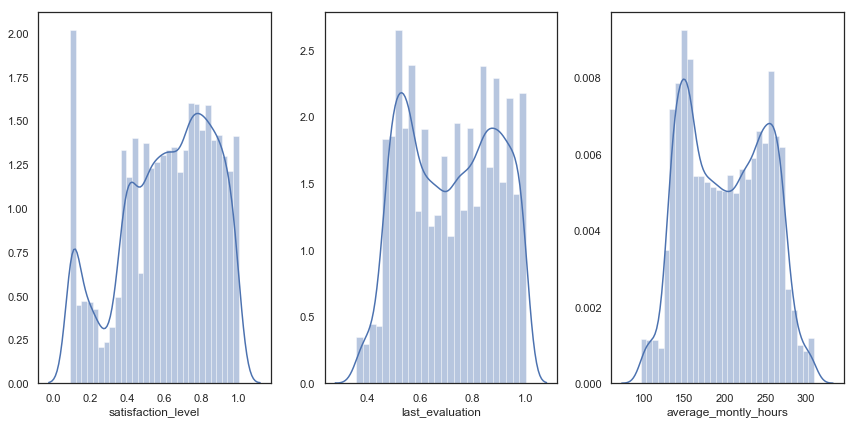

<Figure size 432x288 with 0 Axes>

In [8]:
fig, axs = plt.subplots(ncols=3,figsize=(12,6))
sns.distplot(dataset["satisfaction_level"], ax=axs[0])
sns.distplot(dataset["last_evaluation"], ax=axs[1])
sns.distplot(dataset["average_montly_hours"], ax=axs[2])
plt.tight_layout()
plt.show()
plt.gcf().clear()

These Distribution Plots show something very interesting: it appears that there are two distributions mixed - bi-normal distribution - in satisfaction_level, last_evaluation and average_montly_hours data distributions. It raises the question whether that could correspond to employees who stayed and left.

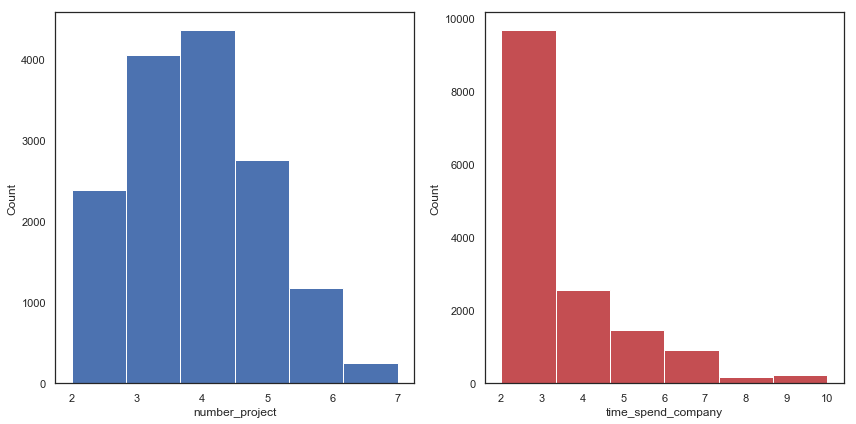

<Figure size 432x288 with 0 Axes>

In [9]:
fig, axs = plt.subplots(ncols=2,figsize=(12,6))
axs[0].hist(dataset["number_project"],bins=6)
axs[0].set_xlabel("number_project")
axs[0].set_ylabel("Count")
axs[1].hist(dataset["time_spend_company"],bins=6,color="r")
axs[1].set_xlabel("time_spend_company")
axs[1].set_ylabel("Count")
plt.tight_layout()
plt.show()
plt.gcf().clear()

The number of projects and the time spend in company seem to follow an Extreme Value Distribution (Gumbel Distribution), considering, nevertheless, that Time_spend_company is very positively skewed (right skewed).

<img src="gumbel.png">

## Correlation Matrix

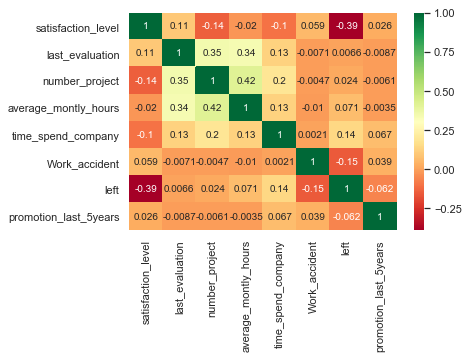

In [10]:
g = sns.heatmap(dataset.corr(),annot=True,cmap="RdYlGn")

It seems that overall hard working employees and ones with several projects have a better evaluation.

corr(number_project,last_evaluation) : 0.35, corr(average_montly_hours,last_evaluation) : 0.34

One of the most impresisve correlations is negative one between 'left' and 'satifaction_level' (-0.39), which would indicate that generally **employees leave due to unhapiness at work **

Still, this analysis lacks an understanding of deeper patterns and raises the question if this is the only and main explanation for employee turnover. To adress these questions, a detailed analysis of the data was done.


## 4. Detailed data exploration

Initially a dimensionality reduction is performed - with two methods: PCA and Isomap - in order to separations and different groups.

### Dimensionality Reduction

In [11]:
dataset = dataset.drop(labels=["sales"],axis = 1)

In [12]:
dataset["salary"] = dataset["salary"].astype("category",ordered=True, categories = ['low','medium','high']).cat.codes

In [13]:
dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary
0,0.38,0.53,2,157,3,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1
2,0.11,0.88,7,272,4,0,1,0,1
3,0.72,0.87,5,223,5,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0


### 4.1 Normalisation and Dimensionalty Reduction

In [14]:
# pca/isomap analysis

N = StandardScaler()

N.fit(dataset)

dataset_norm = N.transform(dataset)

The data is normalized before the demensionality reduction is performed.

In [15]:
index = np.random.randint(0,dataset_norm.shape[0],size=10000)

To reduce the high memory usage of the Isomap Algorithm (higly data greedy), 10 000 points were randomly chosen in the dataset to perform the analysis in. The Isomap and PCA maps generated this way are very similar to the ones obtained from the full dataset and are still much faster to compute.

In [16]:
pca = PCA(n_components=2)
pca_representation = pca.fit_transform(dataset_norm[index])

In [17]:
iso = Isomap(n_components=2, n_neighbors=40)
iso_representation = iso.fit_transform(dataset_norm[index])

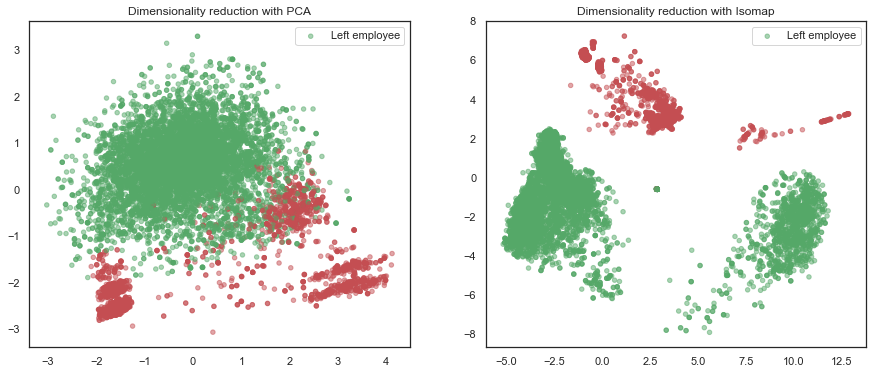

In [18]:
left_colors = dataset["left"].map(lambda s : "g" if s==0 else "r")

fig, axes = plt.subplots(1,2,figsize=(15,6))

axes[0].scatter(pca_representation[:,0],pca_representation[:,1],
            c = left_colors[index],alpha=0.5,s=20)
axes[0].set_title("Dimensionality reduction with PCA")
axes[0].legend(["Left employee"])

axes[1].scatter(iso_representation[:,0],iso_representation[:,1],
            c = left_colors[index],alpha=0.5,s=20)
axes[1].set_title("Dimensionality reduction with Isomap")
axes[1].legend(["Left employee"])


Red points correspond to employees who left. PCA does not show, in this case, a great separation between leaving and staying employees. The PCA algorithm performs a linear demensionality reduction, and the components produced by PCA are a linear combination of the existing features. This works greatly with linearly related features, but indicates, in this case, that the variables are likely non-linearly related.

Isomap provides a non-linear approach, which appears to indicate proper correlations at this point. A great separation can be seen between the red and green points, in the ISOMAP (right graph). Also interesting is the presence of two groups of employees who stayed (green points).

### Let's represent this with an interactive plot

In [19]:
source_dataset = ColumnDataSource(
        data = dict(
            x = iso_representation[:2000,0],
            y = iso_representation[:2000,1],
            desc = dataset.loc[index,"left"],
            colors = ["#%02x%02x%02x" % (int(c*255), int((1-c)*255), 0) 
            for c in dataset.loc[index,"left"]],
            satisfaction_level = dataset.loc[index,'satisfaction_level'],
            last_evaluation = dataset.loc[index,'last_evaluation'],
            number_project = dataset.loc[index,'number_project'],
            time_spend_company = dataset.loc[index,'time_spend_company'],
            average_montly_hours = dataset.loc[index,'average_montly_hours']))
        
hover = HoverTool(tooltips=[("Left", "@desc"), 
                       ("Satisf. level", "@satisfaction_level"),
                       ("#projects", "@number_project"), 
                       ("Last eval.", "@last_evaluation"),
                       ("Time in Company", "@time_spend_company"),
                       ("Montly hrs", "@average_montly_hours")])

tools_isomap = [hover, "box_zoom",'pan', 'wheel_zoom', 'reset']

plot_isomap = figure(plot_width= 800, plot_height=600, tools=tools_isomap, 
                     title='Isomap projection of employee data')
plot_isomap.scatter('x', 'y', size=7, fill_color = "colors", line_color = None,
                    fill_alpha = 0.6, radius=0.1, alpha=0.5, line_width=0,
                    source=source_dataset)
show(plot_isomap)

Hovering and clicking the data points shows major features. 

### 4.2 Global Radar Chart

In [20]:
data_stay = dataset[dataset["left"]==0]
data_left = dataset[dataset["left"]==1]

For practical reasons, 'left' and 'stay' data are separated.

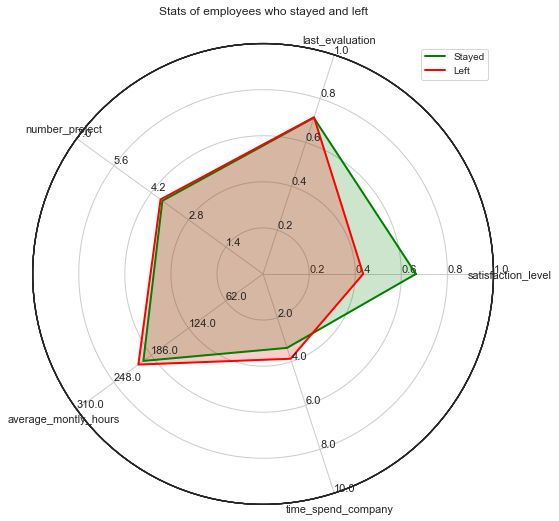

In [21]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]


class RadarChart():
    def __init__(self, fig, variables, ranges, n_ordinate_levels = 6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.8,0.8],polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]
        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            txt.set_rotation(angle - 90)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.1f}".format(x) for x in grid[1:]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)


attributes = ['satisfaction_level','last_evaluation','number_project',
              'average_montly_hours','time_spend_company']



data_stay_mean = data_stay[attributes].mean().values.reshape(1,-1)
data_left_mean = data_left[attributes].mean().values.reshape(1,-1)

datas = np.concatenate((data_stay_mean,data_left_mean),axis = 0)

ranges = [[1e-2, dataset[attr].max()] for attr in attributes]
colors = ["green","red"]
left_types = ["Stayed","Left"]


fig = plt.figure(figsize=(8, 8))
radar = RadarChart(fig, attributes, ranges)

for data, color, left_type in zip(datas, colors, left_types):
    radar.plot(data, color = color, label = left_type, linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = color)
    radar.legend(loc = 1, fontsize = 'medium')

plt.title('Stats of employees who stayed and left')
plt.show()

This radar chart does not appear to show relevant diffrences between employees that left or stayed. At first glance the main difference seems to be the satisfaction level only. As we demonstrated above, employees who left are generally less "happy" or satisfacted than others.

However this radar chart is build on the means of each feature, so it could potentially hide some sub-distributions in the data. Further investigation will be done on this.

### 4.3 Left and other features

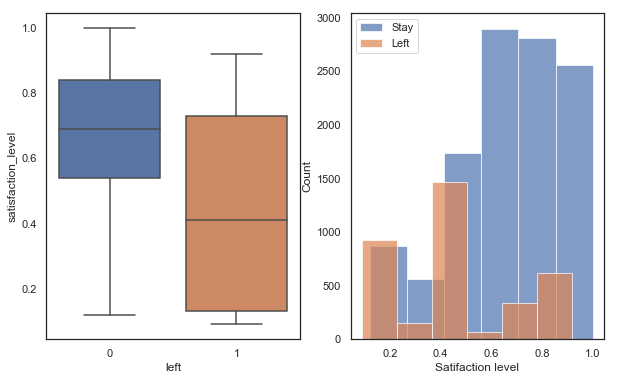

<Figure size 360x360 with 0 Axes>

In [22]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
sns.factorplot(y="satisfaction_level",x="left",data=dataset,kind="box", ax=axs[0])
axs[1].hist(data_stay["satisfaction_level"],bins=6,label="Stay",alpha=0.7)
axs[1].hist(data_left["satisfaction_level"],bins=6,label="Left",alpha=0.7)
axs[1].set_xlabel("Satifaction level")
axs[1].set_ylabel("Count")
axs[1].legend()
plt.tight_layout()
plt.gcf().clear()

The satisfaction level is the strongly correlated with the target feature ('left'). Here we can see that generally employees who left have a lower satisfaction level that those who stayed.

We can also noticed the three sub-distributions of satisfaction levels with employees who left. It would be interesting to understand if these correspond to possibly three different groups:

- Left employees with a low satisfaction level
- Left employees with a medium satisfaction level
- Left employees with a high satisfaction level

## Salary Proportion

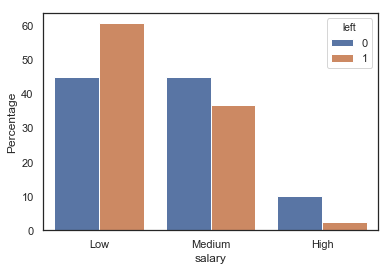

In [23]:
salary_counts = (dataset.groupby(['left'])['salary']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())
p = sns.barplot(x="salary", y="percentage", hue="left", data=salary_counts)
p.set_ylabel("Percentage")
p = p.set_xticklabels(["Low","Medium","High"])

Investigating the salary of employees who left/stayed. The percentage of the employees with a low/medium/high salary in the two categories is shown. A possible explanation would be that

- Employees who left have a lower salary than others

This also raises the question of whether this could be reason why they left.

## Work Proportion

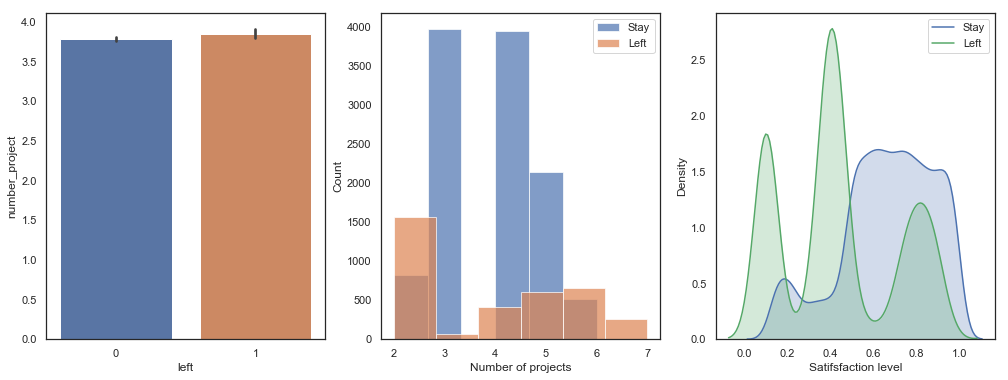

<Figure size 360x360 with 0 Axes>

In [24]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(17,6))

sns.factorplot(y="number_project",x="left",data=dataset,kind="bar", ax=axs[0])

axs[1].hist(data_stay["number_project"],bins=6,label="Stay",alpha=0.7)
axs[1].hist(data_left["number_project"],bins=6,label="Left",alpha=0.7)
axs[1].set_xlabel("Number of projects")
axs[1].set_ylabel("Count")
axs[1].legend()

ax = sns.kdeplot(data=data_stay["satisfaction_level"],color='b',shade=True,ax=axs[2])
ax = sns.kdeplot(data=data_left["satisfaction_level"],color='g',shade=True, ax=axs[2])
ax.legend(["Stay","Left"])
ax.set_xlabel('Satifsfaction level')
ax.set_ylabel('Density')

plt.tight_layout()
plt.gcf().clear()

Analysis is now done in the amount of work different employees do. Employees that left and stayed have a similar number of projects. However, when looking in detail, there are two sub populations in the employees who left. Those who have few projects and those who have several.


## Evaluation Proportion

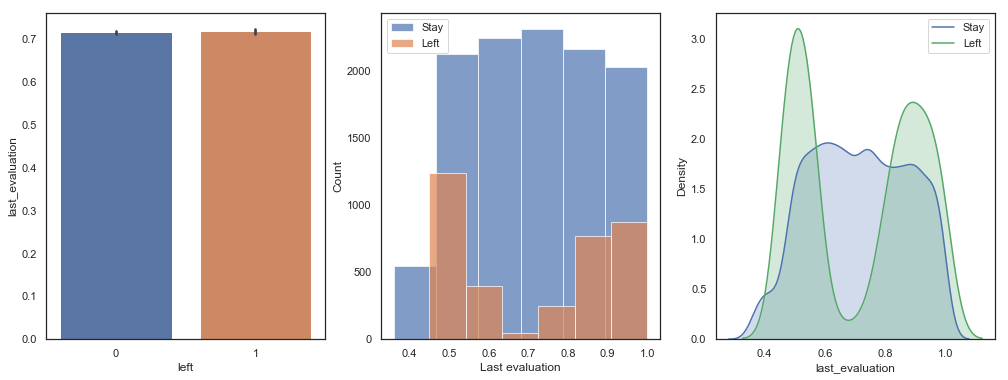

<Figure size 360x360 with 0 Axes>

In [25]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(17,6))

sns.factorplot(y="last_evaluation",x="left",data=dataset,kind="bar", ax=axs[0])

axs[1].hist(data_stay["last_evaluation"],bins=6,label="Stay",alpha=0.7)
axs[1].hist(data_left["last_evaluation"],bins=6,label="Left",alpha=0.7)
axs[1].set_xlabel("Last evaluation")
axs[1].set_ylabel("Count")
axs[1].legend()

ax = sns.kdeplot(data=data_stay["last_evaluation"],color='b',shade=True, ax=axs[2])
ax = sns.kdeplot(data=data_left["last_evaluation"],color='g',shade=True, ax=axs[2])
ax.legend(["Stay","Left"])
ax.set_xlabel('last_evaluation')
ax.set_ylabel('Density')

plt.tight_layout()
plt.gcf().clear()

When we look at the last evaluation we still have two sub populations of employees that left. Those with a medium score and those with an high score, which is interesting indeed.

## Monthly Hours Proportion

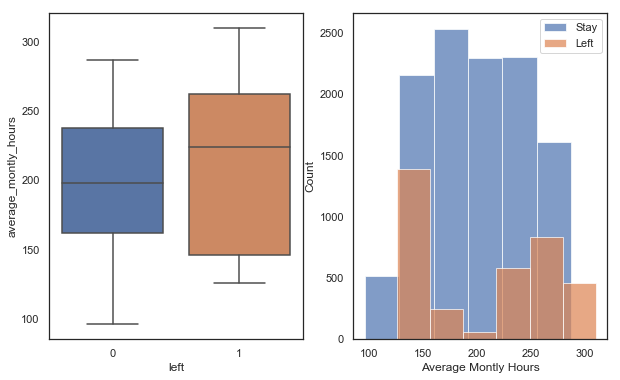

<Figure size 360x360 with 0 Axes>

In [26]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
sns.factorplot(y="average_montly_hours",x="left",data=dataset,kind="box", ax=axs[0])
axs[1].hist(data_stay["average_montly_hours"],bins=6,label="Stay",alpha=0.7)
axs[1].hist(data_left["average_montly_hours"],bins=6,label="Left",alpha=0.7)
axs[1].set_xlabel("Average Montly Hours")
axs[1].set_ylabel("Count")
axs[1].legend()
plt.tight_layout()
plt.gcf().clear()

Similarly to the evaluation score and the number of projects, there are two sub populations of employees who left, depending upon how many mothly hours they put in.

## PairPlot

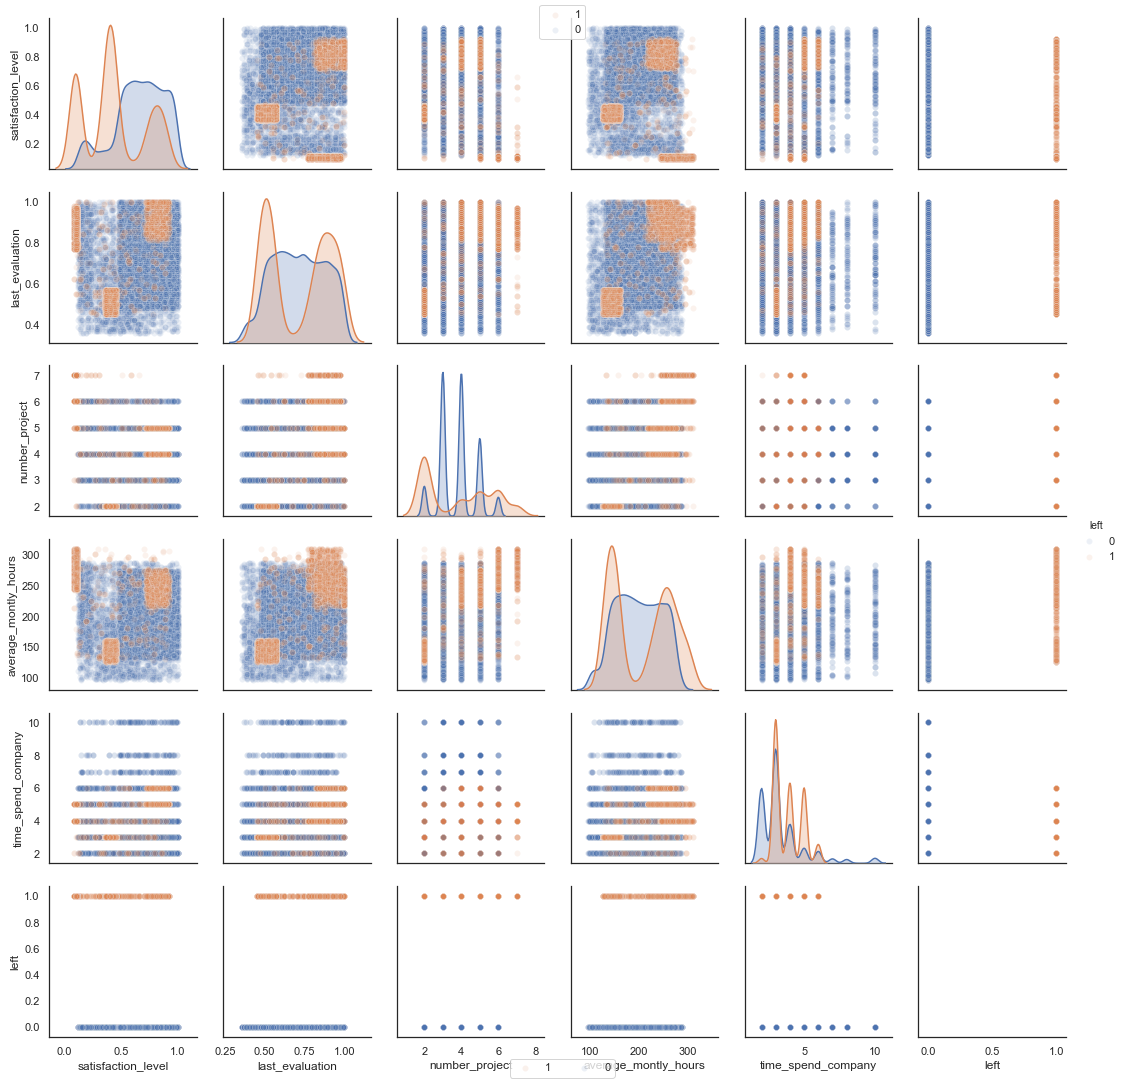

In [27]:
g = sns.pairplot(dataset.drop(labels=['promotion_last_5years','Work_accident','salary'],axis=1),hue="left",plot_kws=dict(alpha=0.1))
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3)

The pairplot shows very interesting patterns when plotting the average monthly hours against the satisfaction level or the satifaction level against the evaluation score. Further these groups will be analyzed in detail.

## Company Evaluation vs. Employee Satisfaction

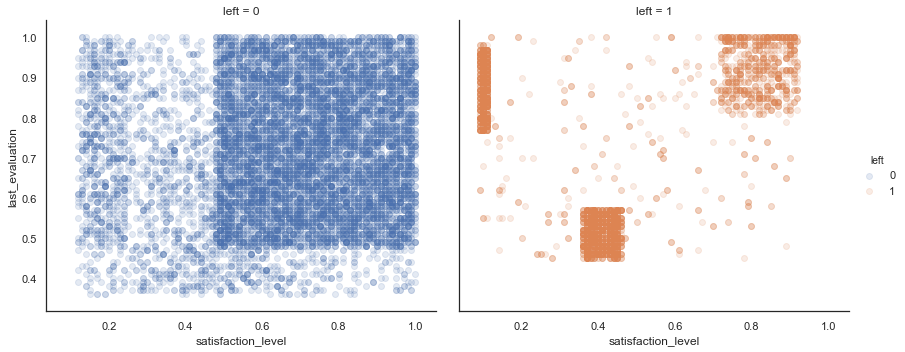

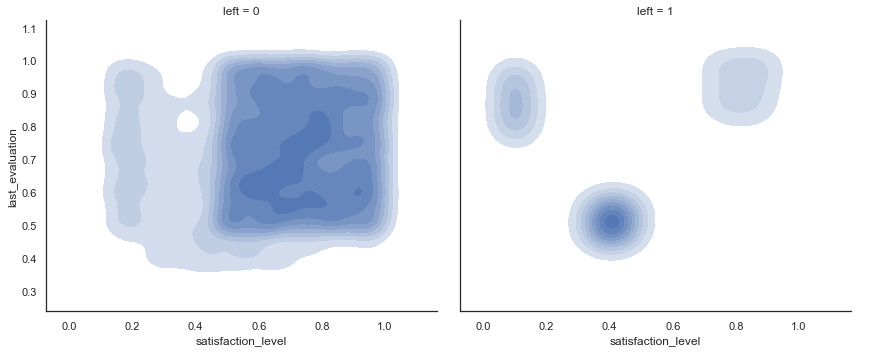

In [28]:
# Deeper in the analysis
g = sns.FacetGrid(dataset, col="left", hue="left",size=5,aspect=1.2)
g.map(plt.scatter, "satisfaction_level", "last_evaluation",alpha=0.15)
g.add_legend()

g = sns.FacetGrid(dataset, col="left",size=5,aspect=1.2)
g.map(sns.kdeplot, "satisfaction_level", "last_evaluation",shade=True,shade_lowest=False)
g.add_legend()

Very interestingly, three groups of employees who left can be detected:

    - Successfull but unhappy employees (top left)
    - Successfull and happy employees (top right)
    - Unsuccessfull and unhappy employees (bottom center)
    
Now an attempt will be made to label the data within this three groups.

### 4.4 Clustering analysis

In [29]:
# Lets compare inside the 3 identified groups

kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(data_left[["satisfaction_level","last_evaluation"]])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=2, tol=0.0001, verbose=0)

Initially kmean clustering is performed to isolate these three groups.

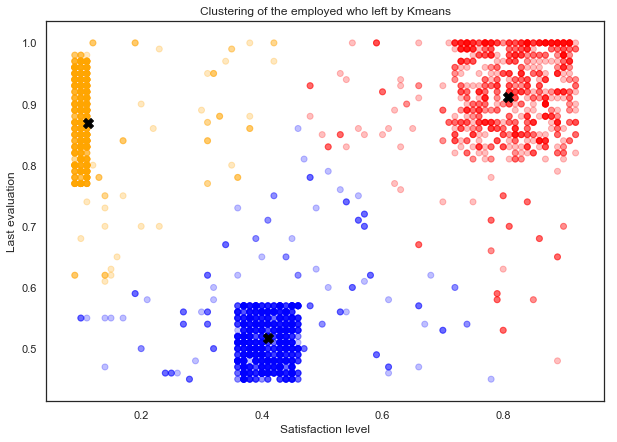

In [30]:
kmeans_colors = ['red' if c == 0 else 'orange' if c == 2 else 'blue' for c in kmeans.labels_]

fig = plt.figure(figsize=(10, 7))
plt.scatter(x="satisfaction_level",y="last_evaluation", data=data_left,
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Satisfaction level")
plt.ylabel("Last evaluation")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clustering of the employed who left by Kmeans")

plt.show()

The cluster center are the three black crosses.

The three groups are defined as : 
    - SuccessUnhappy (yellow) == Successfull but unhappy employees (top left)
    - SuccessHappy (red) == Successfull and happy employees (top right)
    - UnsuccessUnhappy (blue) == Unsuccessfull and unhappy employees (bottom center)

In [31]:
data_left_SuccessHappy = data_left[kmeans.labels_ == 0]
data_left_UnsuccessUnhappy = data_left[kmeans.labels_ == 1]
data_left_SuccessUnhappy = data_left[kmeans.labels_ == 2]

In [32]:
data_left_SuccessUnhappy.shape

(944, 9)

In [33]:
data_left_SuccessHappy.shape

(977, 9)

In [34]:
data_left_UnsuccessUnhappy.shape

(1650, 9)

In [35]:
data_left_SuccessUnhappy_mean = data_left_SuccessUnhappy[attributes].mean().values.reshape(1,-1)
data_left_SuccessHappy_mean = data_left_SuccessHappy[attributes].mean().values.reshape(1,-1)
data_left_UnsuccessUnhappy_mean = data_left_UnsuccessUnhappy[attributes].mean().values.reshape(1,-1)

datas = np.concatenate((data_stay_mean,data_left_SuccessUnhappy_mean, 
                        data_left_SuccessHappy_mean,data_left_UnsuccessUnhappy_mean),axis = 0)

## Radar Plot Considering Clustered Groups

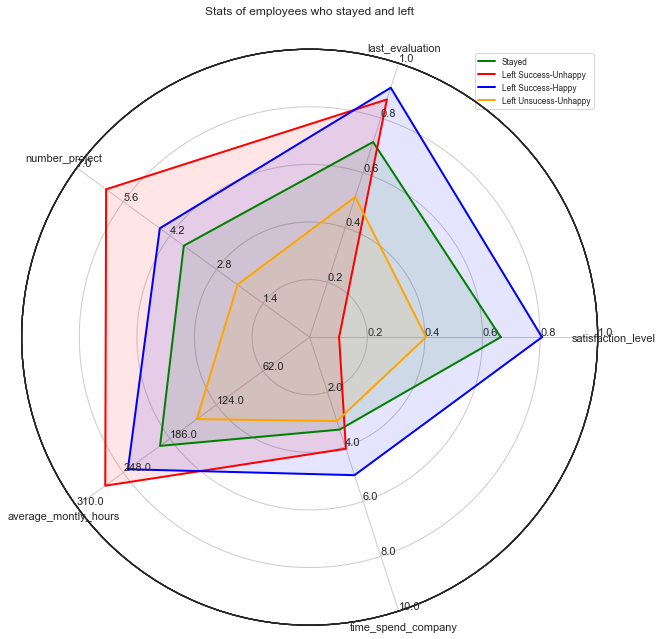

In [36]:
colors = ["green","red","blue","orange"]
left_types = ["Stayed","Left Success-Unhappy", "Left Success-Happy", "Left Unsucess-Unhappy"]

fig = plt.figure(figsize=(10, 10))
radar = RadarChart(fig, attributes, ranges)
for data, color, left_type in zip(datas, colors, left_types):
    radar.plot(data, color = color, label = left_type,linewidth=2.0)
    radar.fill(data, alpha = 0.1, color = color)
    radar.legend(loc = 1, fontsize = 'small')
plt.title('Stats of employees who stayed and left')
plt.show() 

Finally, the three groups show significant differences which could correspond strongly to the different types and personalities of employees that left. Comparing the three groups and the group of employees who stayed it is possible to better understand them.

Some really interesting conclusions and projections can be extracted from this:

**- It appears that the Successful-Unhappy group of employees are those who work the most, with 6 projects and more than 300 h/month. These employees might left due to being overworked.**

**- The Unsuccessful-Unhappy group might have left because they of lack of involvment in their company. They have few projects and generally work less than the others.**

**- The Successful-Happy group is the closest to the group of employees that stayed, except that they have spent a long time in the company. They might have left as a natural cycle of turnover for new opportunities.**

These conclusions allow to proceed to the Modelling phase.

## 5. Modeling

The objective is to obtain a model that predicts the target variable with high accuracy and explore the features weights and importances.

In [37]:
## Prediction of the target variable (stay/left) 

X_train = dataset.drop(labels = "left",axis = 1)

Y_train = dataset["left"]

train_features = X_train.columns

In [38]:
kfold = StratifiedKFold(n_splits=10,random_state=2)

### 5.1 Decision Tree
The Decision Tree algorithm is considered to in order to study the importance of features in data modeling.

In [39]:
DTC = DecisionTreeClassifier(max_depth=3)

cv_results = cross_val_score(DTC,X_train, Y_train, cv=kfold, scoring="accuracy")

cv_results.mean()

0.9523907907218329

The depth of the tree is restricted to 3 to build a simple tree for quick analysis. Despite the simplicity of this tree, a sufficient 95% accuracy is achieved.

In [40]:
DTC.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

The tree structure is plotted to look at the most important features.

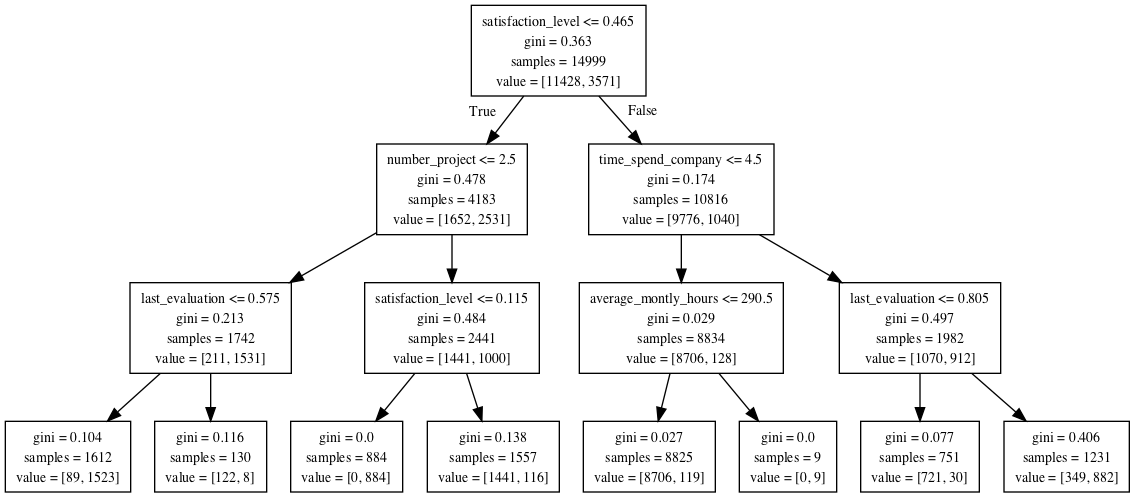

In [41]:
## NOT WORKING ON KAGGLE SERVERS (no module pydot nor pydotplus)####
dot_data = StringIO()

tree.export_graphviz(DTC, out_file=dot_data,feature_names=train_features)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
graph.set_lwidth(400)
graph.set_lheight(300)

Image(graph.create_png())

# I have uploaded an image instead.

![](http://img1.imagilive.com/0817/graph_DTC.png)

The Decision Tree structure reveals the most relevant variable for predicting at the top: employee's satisfaction level. It is interesting that 4 groups can be detected (SuccessHappy, UnsuccessUnhappy, SuccessUnhappy, stay) and their caracteristics are as follows:

- The path with (satisf.level <=0.465 [True] -> number_project <= 2.5 [True] -> last_evaluation <= 0.57 [True]) corresponds to the Unsuccessful-Unhappy group.


- The path with satisf.level <=0.465 [True] -> number_project <= 2.5 [False] -> last_evaluation <= 0.115 [True] corresponds to the Successful-Unhappy group.


- The path with (satisf.level <=0.465 [False] -> time_spend_company <= 4.5 [False] -> last_evaluation <= 0.805 [False]) corresponds to the Successful-Happy group.


- The path with (satisf.level <=0.465 [False] -> time_spend_company <= 4.5 [True] -> average_monty_hours <= 290.5 [True]) the most prominent part of the 'stay' group (76%).

This decision tree we gives a clear understanding of the reasons employee's might have left.

In [42]:
# For those who like performance, 99% accuracy

RFC = RandomForestClassifier()

cv_results = cross_val_score(RFC,X_train, Y_train, cv=kfold, scoring="accuracy")

cv_results.mean()

0.9914000887704099

In [43]:
RFC.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary
0,0.38,0.53,2,157,3,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1
2,0.11,0.88,7,272,4,0,1,0,1
3,0.72,0.87,5,223,5,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0


In [45]:
dataset.iloc[[2]]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary
2,0.11,0.88,7,272,4,0,1,0,1


In [46]:
print(RFC.predict([[0,0,0,0,0,0,0,0]]))

[0]


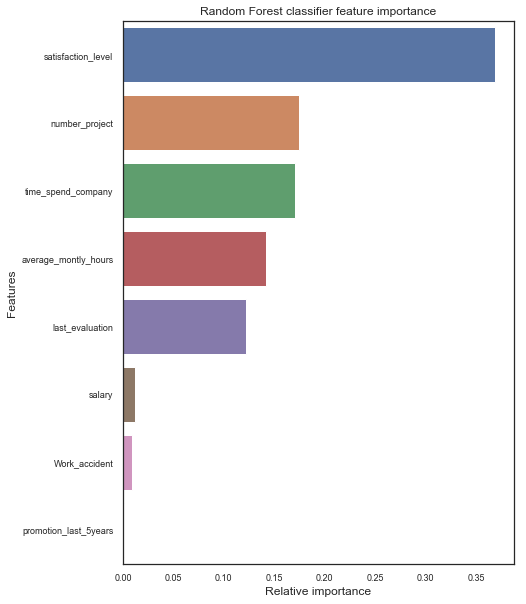

<Figure size 432x288 with 0 Axes>

In [47]:
indices = np.argsort(RFC.feature_importances_)[::-1][:40]

fig = plt.figure(figsize=(7, 10))
g = sns.barplot(y=train_features[indices][:40],x = RFC.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Random Forest classifier feature importance")

plt.show()
plt.gcf().clear()

Satisfaction_level average_montly_hours, number_project, time_spend_company and last_evaluation appear to be the five most relevant features that explain why employees might leave or stay in a certain company. Salary, work accidents and promotions seem less relevant.

# Exporting Model for further use in FrontEnd

In [48]:
import pickle

pickle.dump(RFC,open("spotKernel.pkl","wb"), protocol=2)